In [1]:
import popoff
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
from average_traces import SingleCells
from scipy import stats
import os
import pickle
import math
import copy
from Session import Session, SessionLite
import seaborn as sns

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py


In [2]:
# global plotting params
sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

In [3]:
def load_run(session):
    run_path = os.path.join(session.pkl_path, session.mouse,
                            f'run{session.run_number}.pkl')
    
    with open(run_path, 'rb') as f:
        r = pickle.load(f)
        session.run = r
    return session

In [4]:
single = SingleCells()
# Refactor code here out into this class when need to reuse
sessions = single.sessions

In [5]:
def get_range(session, plot=False):

    if session.mouse == 'RL048' or session.mouse == 'J048':
        post_range = [28,35]
        pre_range = [0, 10]
    else:
        post_range = [180, 250]
        pre_range = [0, 75]

    if plot:
        plt.figure()
        plt.plot(np.mean(arr, (0,1)))

        for pre, post in zip(post_range, pre_range):
            plt.axvline(pre, color='blue')
            plt.axvline(post, color='red')
    
    return pre_range, post_range

In [6]:
def average_cell_plotter(arr, cell_idx, trials_use, color, label):
    cell  = arr[cell_idx, trials_use, :]
    
    mean = np.mean(cell, 0)
    plt.plot(x_axis, mean, color=color, label=label)
    
    sem = np.std(cell, 0) / math.sqrt(cell.shape[0])
    plt.fill_between(x_axis, mean-sem, mean+sem, color=color)

    plt.legend()

In [49]:
def compare_prepost(arr, trials_use, cells_use, pre_range, post_range):
    
    if cells_use != 'all':
        arr  = arr[cells_use, :, :]
    if trials_use != 'all':
        arr  = arr[:, trials_use, :]
    pre  = arr[:, :, pre_range[0]:pre_range[1]]
    post = arr[:, :, post_range[0]:post_range[1]]
    
    # Prepost diff for each cell for each trial
    diff = np.mean(post, 2) - np.mean(pre, 2)
    
    # Return prepost differnece for each cell
    return np.mean(diff, 1)

In [53]:
def hit_tuned(arr, pre_range, post_range):
    
    tuning = (
               compare_prepost(arr, trials_use=session.outcome=='hit', cells_use='all', 
                               pre_range=pre_range, post_range=post_range)
             - compare_prepost(arr, trials_use=session.outcome=='miss', cells_use='all',
                               pre_range=pre_range, post_range=post_range)
             )
    
    return np.flip(np.argsort(tuning))

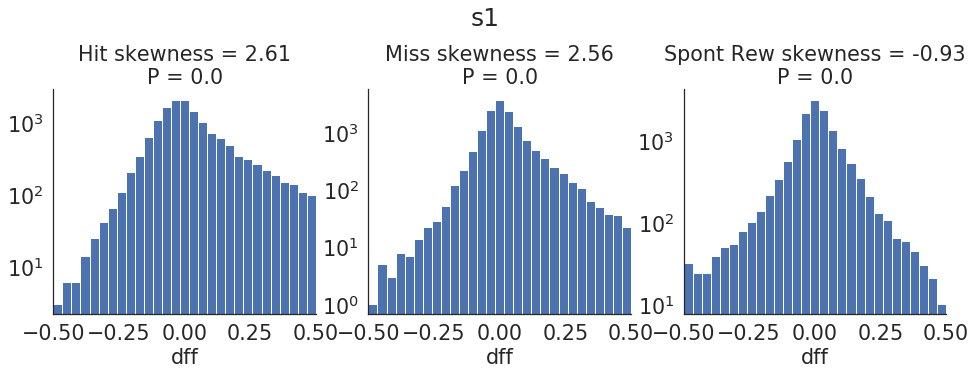

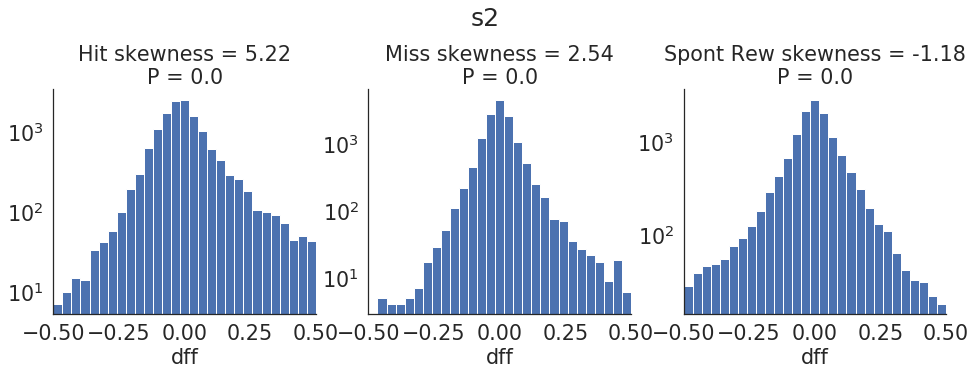

In [9]:
for idx, area in enumerate(['s1', 's2']):
    
    hit = []
    miss = []
    pre_rew = []
    
    for _, session in sessions.items():

        arr = session.behaviour_trials
        
        if area == 's1':
            cells_use = session.s1_bool
        elif area == 's2':
            cells_use = session.s2_bool
            
        pre_range, post_range = get_range(session, plot=False)
        
        hit.append(
            compare_prepost(arr, trials_use=session.outcome=='hit', cells_use=cells_use,
                            pre_range=pre_range, post_range=post_range)
        )
        miss.append(
            compare_prepost(arr, trials_use=session.outcome=='miss', cells_use=cells_use,
                            pre_range=pre_range, post_range=post_range)
        )

        ## TODO remove nan trials
        arr = session.pre_rew_trials
        
        pre_rew.append(
            compare_prepost(arr, trials_use=np.repeat(True, arr.shape[1]),
                            cells_use=cells_use, pre_range=pre_range, post_range=post_range)
        )
        
        
    hit = np.concatenate(hit)
    miss = np.concatenate(miss)
    pre_rew = np.concatenate(pre_rew)
    pre_rew = pre_rew[~np.isnan(pre_rew)]
    

    fig = plt.figure(figsize=(16,5))
    fig.subplots_adjust(top=0.75) 
    plt.suptitle(area, fontsize=25)

    n_bins = 30
    xlim = (-0.5, 0.5)
    bins = np.linspace(xlim[0], xlim[1], n_bins)

    ax1 = plt.subplot(1,3,1)
    ax1.set_title(f'Hit skewness = {round(stats.skew(hit), 2)}\nP = {round(stats.skewtest(hit)[1], 2)}')
    h = ax1.hist(hit, bins)

    ax2 = plt.subplot(1,3,2)
    ax2.set_title(f'Miss skewness = {round(stats.skew(miss), 2)}\nP = {round(stats.skewtest(miss)[1], 2)}')
    h = ax2.hist(miss, bins)

    ax3 = plt.subplot(1,3,3)
    ax3.set_title(f'Spont Rew skewness = {round(stats.skew(pre_rew), 2)}\nP = {round(stats.skewtest(pre_rew)[1], 2)}')
    h = ax3.hist(pre_rew, bins)

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('dff')
        ax.set_yscale('log')
        ax.set_xlim(xlim)



In [ ]:
def compare_prepost_tbt(arr, pre_range, post_range, cells_use='all', trials_use='all'):
    
    if cells_use != 'all':
        arr  = arr[cells_use, :, :]
    if trials_use != 'all':
        arr  = arr[:, trials_use, :]
    pre  = arr[:, :, pre_range[0]:pre_range[1]]
    post = arr[:, :, post_range[0]:post_range[1]]
    
    mean_pre = np.mean(pre, axis=2)
    std_pre = np.std(pre, axis=2)
    
    mean_post = np.mean(post, axis=2)
    
    
    # commented out if look at excited and inhibited
    #bool_mat = np.logical_or(mean_post > (mean_pre + 2*std_pre), (mean_post < mean_pre - 2*std_pre))
    bool_mat = mean_post > (mean_pre + 2*std_pre)
    p_activated = np.sum(bool_mat, axis=1) / bool_mat.shape[1]
    
    sort_idx = np.flip(np.argsort(np.sum(bool_mat, axis=1)))
    bool_mat = bool_mat[sort_idx, :]
    
    
    return bool_mat, p_activated

In [37]:

hits = []
misses = []
for _, session in sessions.items():
    arr = session.behaviour_trials
    pre_range, post_range = get_range(session, plot=False)
    
    _, hit = compare_prepost_tbt(arr, pre_range, post_range, 
                                 trials_use=session.outcome=='hit', cells_use=session.s2_bool)
    _, miss = compare_prepost_tbt(arr, pre_range, post_range, 
                                  trials_use=session.outcome=='miss', cells_use=session.s2_bool)
    
    hits.append(hit)
    misses.append(miss)

hits = np.concatenate(hits)
misses = np.concatenate(misses)

/home/jrowland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jrowland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


In [44]:
rho, p = stats.spearmanr(hits, misses)
rho

0.6276684298663984

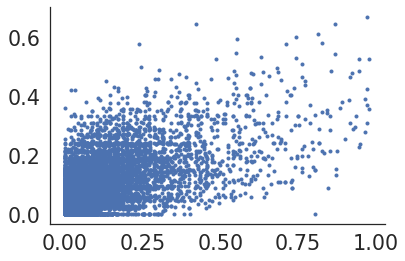

In [42]:
plt.plot(hits, misses, '.')

/home/jrowland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


([<matplotlib.axis.XTick at 0x7fdf6881a3d0>,
 <a list of 2 Text xticklabel objects>)

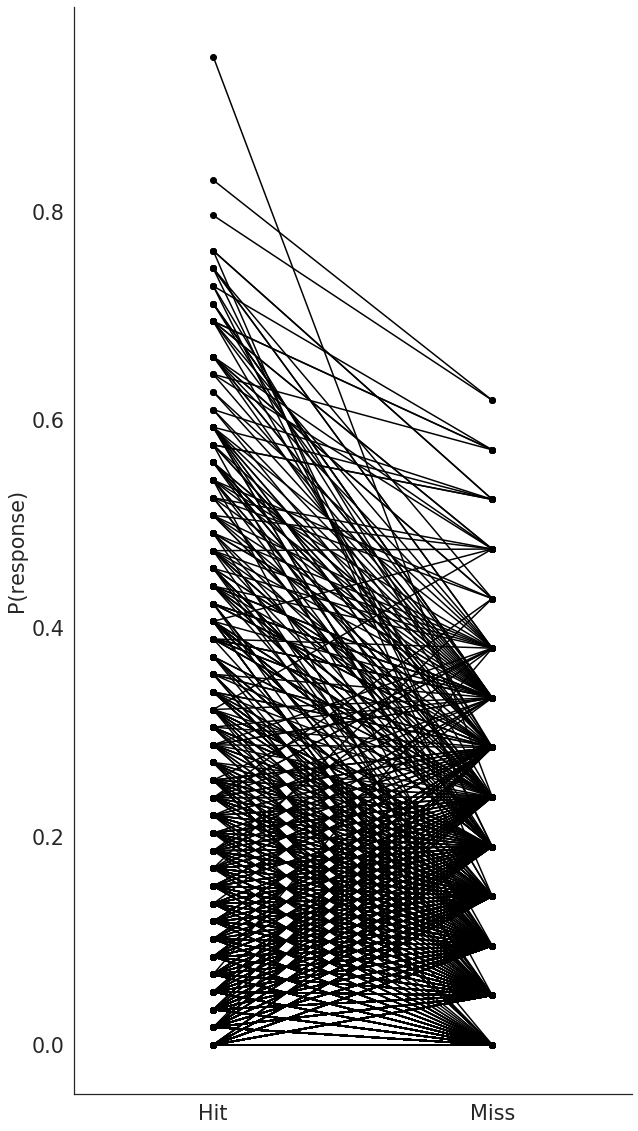

In [12]:
session = sessions[2]
arr = session.behaviour_trials
pre_range, post_range = get_range(session, plot=False)

_, hit = compare_prepost_tbt(arr, pre_range, post_range, trials_use=session.outcome=='hit')
_, miss = compare_prepost_tbt(arr, pre_range, post_range, trials_use=session.outcome=='miss')

plt.figure(figsize=(10,20))
for h, m in zip(hit, miss):
    plt.plot([0,1], [h,m], color='black', marker='o')

plt.xlim(-0.5, 1.5)
plt.ylabel('P(response)')
plt.xticks([0,1], ('Hit', 'Miss'))

In [18]:
s1, _ = compare_prepost_tbt(arr, trials_use=session.outcome=='hit', cells_use = session.s1_bool, pre_range=pre_range, post_range=post_range)
s2, _ = compare_prepost_tbt(arr, trials_use=session.outcome=='hit', cells_use = session.s2_bool,
                        pre_range=pre_range, post_range=post_range)

/home/jrowland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jrowland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


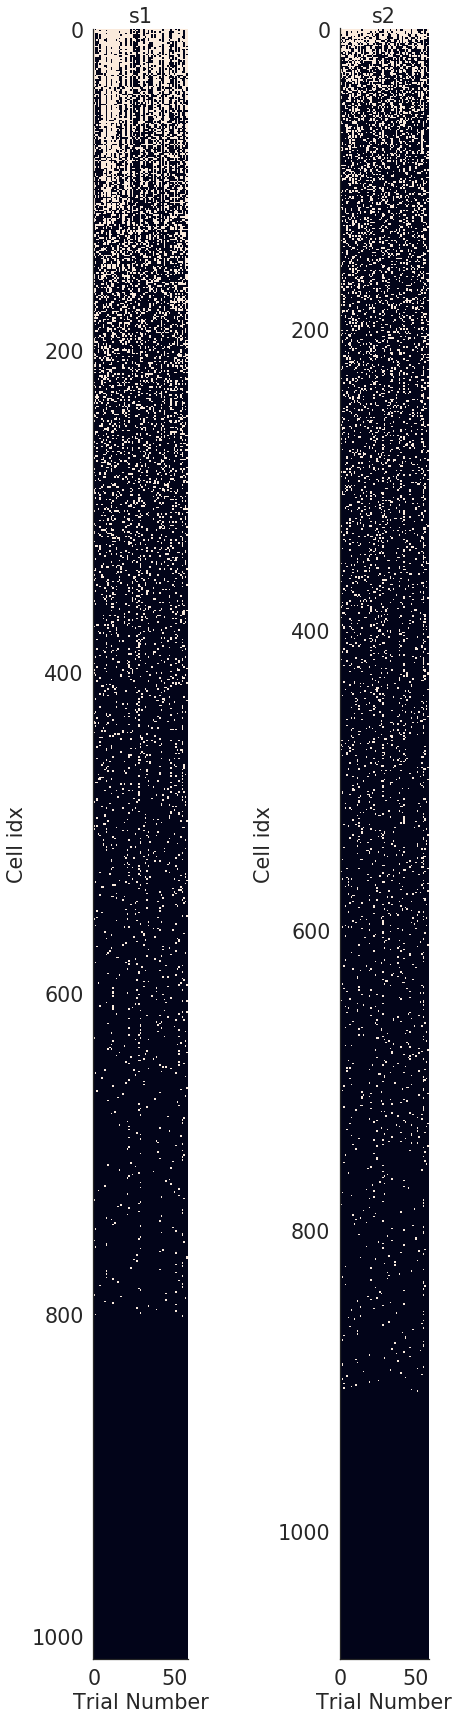

In [19]:
plt.figure(figsize=(8,30))

for idx, area in enumerate([s1, s2]):
    plt.subplot(1,2,idx+1)
    
    plt.title(f's{idx+1}')
    plt.imshow(area)
    plt.ylabel('Cell idx')
    plt.xlabel('Trial Number')

In [57]:
color_tt = {'hit': 'green', 'miss': 'grey', 'fp': 'magenta', 
            'cr': 'brown', 'ur_hit': '#7b85d4', 'ar_miss': '#e9d043',
            'spont_rew': 'darkorange'}


In [60]:
session = sessions[2]
session = load_run(session)
    
flu = session.run.flu

arr = session.behaviour_trials
assert flu.shape[0] == arr.shape[0]
x_axis = session.filter_ps_time

if session.mouse == 'RL048' or session.mouse=='J048':
    fs = 5
else:
    fs = 30

<Figure size 432x288 with 0 Axes>

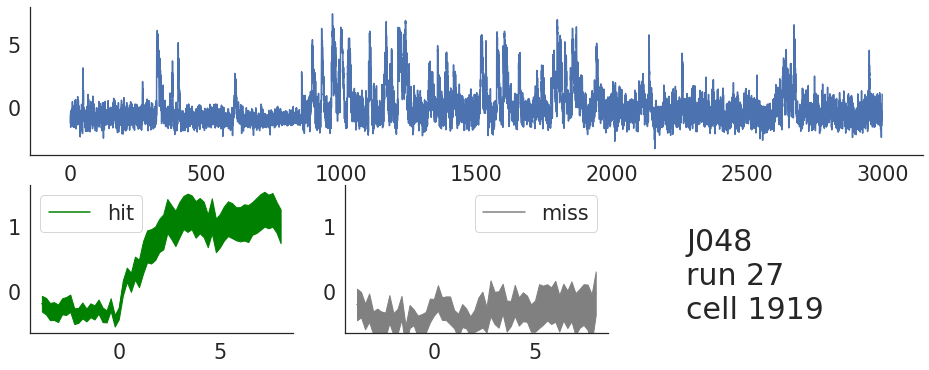

<Figure size 432x288 with 0 Axes>

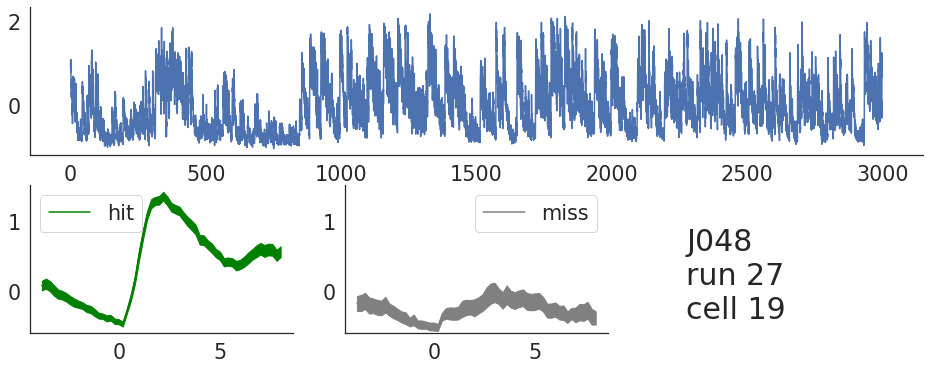

<Figure size 432x288 with 0 Axes>

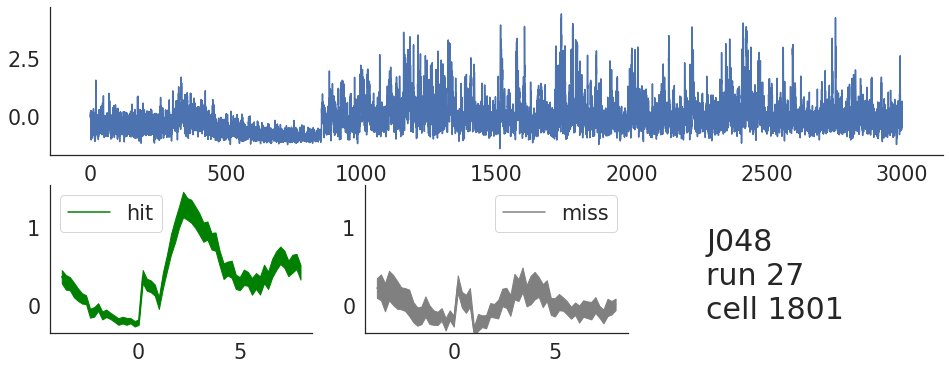

In [61]:
for i in range(3):

    plt.figure()
    
    pre_range, post_range = get_range(session, plot=False)
    
    hit_tuned_idxs = hit_tuned(copy.deepcopy(arr), pre_range, post_range)
    cell_plot = hit_tuned_idxs[i]

    fig = plt.figure(figsize=(16, 6))

    ax1 = fig.add_subplot(2,1,1)
    range_plot = np.arange(0, 15000)
    ax1.plot(range_plot/fs,  flu[cell_plot, range_plot])


    ax2 = fig.add_subplot(2,3,4)

    trial_type = 'hit'
    average_cell_plotter(copy.deepcopy(arr), cell_plot, session.outcome==trial_type, color_tt[trial_type], label=trial_type)
    ax3 = fig.add_subplot(2,3,5)

    trial_type = 'miss'
    average_cell_plotter(copy.deepcopy(arr), cell_plot, session.outcome==trial_type, color_tt[trial_type], label=trial_type)
    ax3.set_ylim(ax2.get_ylim())

    ax4 = fig.add_subplot(2,3,6, frameon=False)
    ax4.text(0.1,0.1, f'{session.mouse}\nrun {session.run_number}\ncell {cell_plot}', fontsize=30)
    ax4.axes.get_yaxis().set_visible(False)
    ax4.axes.get_xaxis().set_visible(False)